<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">ANALYSE DES VENTES DE LA LIBRAIRIE LAPAGE</h2>
</div>

# OBJECTIF DE CE NOTEBOOK

# Analyse des ventes de la librairie Lapage

Ce notebook propose une analyse complète, exploratoire et statistique des données commerciales de la librairie Lapage.  
L’objectif est double : 
- dresser un état des lieux détaillé de l’activité (ventes, clients, produits)
- puis dans un second temps, permettre de décider s’il convient de créer certaines offres, adapter certains prix ou cibler un certain type de clientèle

Les étapes principales sont les suivantes :

1. **Importation, exploration initiale et nettoyage des données** 
2. **Analyse exploratoire** : exploration générale des 3 datasets, traitement des doublons, valeurs manquantes, types, formats et outliers.   
3. **Jointures des fichiers** : fusion des tables avec vérification de l’intégrité des jointures, et gestion des outliers.
4. **Analyses graphiques** : analyses temporelles des ventes et revenus générés. Création de TOP/FLOP, répartition par catégorie, courbe de Lorenz, indice de Gini.  
5. **Tests d'hypothèses et conclusions** : réalisation de tests pour vérifier des hypothèses commerciales, et principaux enseignements et recommandations issues de l’analyse.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
import pingouin as pingouin 
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols

In [2]:
#Importations csv
products = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/products.csv", sep=';')
transactions = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/transactions.csv", sep=';', low_memory=False)
customers = pd.read_csv("C:/Users/AUCLAIR/Documents/Projet_Data_9/customers.csv", sep=';')

In [3]:
# 1. Palette personnalisée pour les catégories
CATEG_PALETTE = {0: '#e9d4cf',   1: '#a06f8d',  2: '#2d223a' }

# 2. Palette générale 
GENERAL_PALETTE = ['#8c5db8','#b08cbf','#a68da8','#b9a7b0','#ded6d1']

In [4]:
# 3. Thème global Seaborn 
sns.set_theme(
    style="whitegrid",
    rc={
        "figure.figsize": (10, 5.5),
        "axes.titlesize": 14,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "axes.labelweight": "bold",
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "font.family": "DejaVu Sans",
        "axes.edgecolor": "#333333",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "figure.facecolor": "white",
        "axes.facecolor": "white",
    }
)

# 4. Palette par défaut
sns.set_palette(GENERAL_PALETTE)

In [5]:
def optimize(df):
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype('category')

    for col in df.select_dtypes('float'):
        df[col] = df[col].astype('float32')

    for col in df.select_dtypes('int'):
        df[col] = df[col].astype('int32')

    return df

products = optimize(products)
transactions = optimize(transactions)
customers = optimize(customers)

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

### Analyse de products :

In [6]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
products.dtypes

id_prod    category
price       float32
categ         int32
dtype: object

In [8]:
doublons= products.duplicated(subset="id_prod")
products[doublons]

,id_prod,price,categ


In [9]:
products.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [10]:
products.describe()

,price,categ
count,3286.000000,3286.000000
mean,21.863598,0.370359
std,29.849785,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [11]:
#Analyse des catégories de produits
products["categ"].unique()

array([0, 1, 2], dtype=int32)

 Il n'y a ni doublons, ni valeurs manquantes pour la table **products**.

### Analyse de transactions :

In [12]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


In [13]:
transactions.dtypes

id_prod       category
date          category
session_id    category
client_id     category
dtype: object

In [14]:
transactions.dtypes

id_prod       category
date          category
session_id    category
client_id     category
dtype: object

In [15]:
transactions.isna().sum()

id_prod       361041
date          361041
session_id    361041
client_id     361041
dtype: int64

In [16]:
len(transactions)

1048575

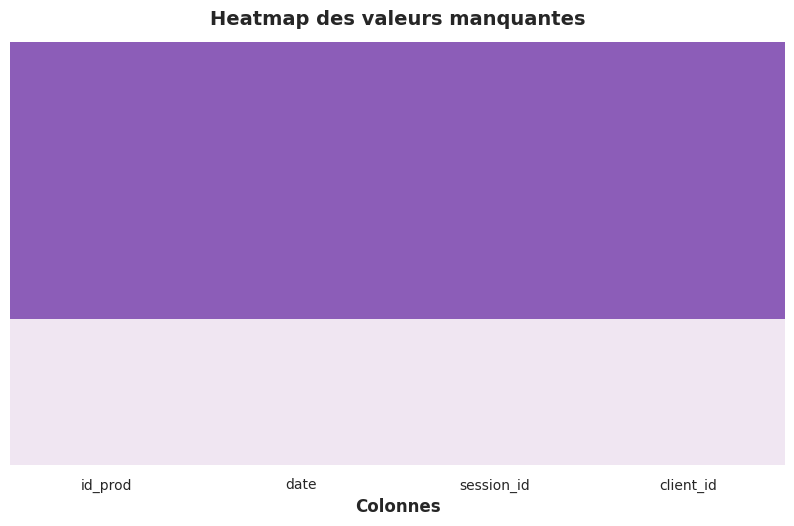

In [17]:
# Heatmap pour visualiser les valeurs manquantes
plt.figure()
sns.heatmap(
    transactions.isnull(),                 # True là où c’est manquant
    yticklabels=False,            # pour des tables larges : évite le chevauchement
    cbar=False,
    cmap = ['#8c5db8', '#f0e6f2']
)
plt.title('Heatmap des valeurs manquantes', y = 1.02)
plt.xlabel('Colonnes')
plt.show()

**Observation :** Environ 33 % des lignes du DataFrame (le dernier tiers) contiennent uniquement des valeurs manquantes sur toutes les colonnes.

In [18]:
#transactions[transactions.isna()]

In [19]:
#Suppression des valeurs manquantes
transactions_NAN = transactions.isna().all(axis=1)
transactions = transactions[~transactions_NAN]
len(transactions)

687534

Je supprime uniquement les lignes dont toutes les colonnes sont manquantes.
Ces observations ne contiennent aucune information exploitable (aucun client, aucun produit, aucun prix, aucune date) et ne peuvent ni être imputées ni contribuer à l’analyse.
Leur maintien pourrait introduire du bruit ou fausser des indicateurs simples (nombre total de transactions).
La suppression de ces lignes est donc justifiée et n’a aucun impact sur la qualité ou l’intégrité des analyses ultérieures.

In [20]:
transactions.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [21]:
#Analyse de la colonne 'date'
transactions['date'] = pd.to_datetime(transactions['date'])
doublons_dates = transactions.duplicated(subset = "date", keep=False)
transactions[doublons_dates]

,id_prod,date,session_id,client_id
197076,1_414,2021-10-02 01:17:27.925296,s_107282,c_70
197077,1_651,2021-10-02 01:17:27.925296,s_107282,c_70
197086,1_311,2021-10-02 01:23:55.310730,s_100028,c_5723
197087,1_495,2021-10-02 01:23:55.310730,s_100028,c_5723
197129,1_288,2021-10-02 02:16:39.453765,s_102820,c_1970
...,...,...,...,...
217993,1_293,2021-10-22 22:28:58.194395,s_109098,c_7272
219528,1_462,2021-10-24 21:11:54.305246,s_101347,c_711
219529,1_245,2021-10-24 21:11:54.305246,s_101347,c_711
220141,1_157,2021-10-25 17:06:59.656670,s_101176,c_436


Je remarque plus d'une centaine de doublons sur la colonne **date**.

In [22]:
# On valide pour pour une même session_id, il peut y avoir, plusiseurs dates 
session_date_counts = transactions.groupby('session_id', observed=True)['date'].nunique()

# Filtrer ceux qui ont plus d'une date
sessions_multi_dates = session_date_counts[session_date_counts > 1]

# Afficher les sessions concernées
print(sessions_multi_dates)

session_id
s_100       2
s_1000      4
s_10000     3
s_100001    2
s_100002    2
           ..
s_99992     2
s_99994     3
s_99996     4
s_99998     3
s_99999     3
Name: date, Length: 181182, dtype: int64


In [23]:
# Période des doublons de date
doublons_octobre_21 = transactions[doublons_dates]
doublons_octobre_21['date'].min(), doublons_octobre_21['date'].max()

(Timestamp('2021-10-02 01:17:27.925296'),
 Timestamp('2021-10-25 17:06:59.656670'))

In [24]:
# Recherche de la nature des doublons
doublons_octobre_21 = transactions[doublons_dates]
grouped = doublons_octobre_21.groupby(['session_id', 'client_id'], observed=True)
duplicated_rows = grouped.filter(lambda x: x['id_prod'].duplicated().any())
print(duplicated_rows.sort_values(by=['session_id', 'client_id', 'id_prod']))

Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []


In [25]:
#Nombre de transactions
nb_transactions = transactions.drop_duplicates(subset=['session_id', 'client_id', 'date']).shape[0]
nb_transactions

687415

In [26]:
# Nombre de produits vendus
len(transactions)

687534

In [27]:
transactions['date'].describe()

count                           687534
mean     2022-03-01 21:24:00.618519296
min         2021-03-01 00:01:07.843138
25%      2021-09-10 10:35:20.642323456
50%      2022-02-27 06:50:25.400120064
75%      2022-08-28 22:16:49.841665536
max         2023-02-28 23:58:30.792755
Name: date, dtype: object

In [28]:
# Range des dates
print(transactions['date'].min(), transactions['date'].max())

2021-03-01 00:01:07.843138 2023-02-28 23:58:30.792755


Je note des doublons sur la colonne **date**, sur le mois d'octobre 2021.

### Analyse de customers :

In [29]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [30]:
# Vérification des valeurs manquantes
customers.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [31]:
# Vérification des doublons
doublons_customers = customers.duplicated(subset='client_id', keep=False)
customers[doublons_customers]

,client_id,sex,birth


In [32]:
customers.dtypes

client_id    category
sex          category
birth           int32
dtype: object

Il n'y a ni doublons, ni valeurs manquantes pour la table **customers**.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Jointure des fichiers</h2>
</div>

### Jointures :

In [33]:
len(products), len(customers), len(transactions)

(3286, 8621, 687534)

In [34]:
# Exécution de la 1ère fusion
df_merge = products.merge(transactions, on = 'id_prod', validate='one_to_many', indicator = True)
df_merge.isna().sum()

id_prod       0
price         0
categ         0
date          0
session_id    0
client_id     0
_merge        0
dtype: int64

In [35]:
df_merge.head(10)

,id_prod,price,categ,date,session_id,client_id,_merge
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,both
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,both
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,both
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,both
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,both
5,0_1421,19.99,0,2021-03-03 11:20:13.284203,s_1163,c_1545,both
6,0_1421,19.99,0,2021-03-05 15:49:32.987064,s_2151,c_1437,both
7,0_1421,19.99,0,2021-03-05 17:10:40.265676,s_2187,c_1455,both
8,0_1421,19.99,0,2021-03-06 04:54:05.505267,s_2419,c_5689,both
9,0_1421,19.99,0,2021-03-07 14:30:19.775495,s_3063,c_8170,both


In [36]:
# Vérification de la jointure
df_merge['_merge'].value_counts()

_merge
both          687534
left_only          0
right_only         0
Name: count, dtype: int64

In [37]:
# Exécution de la 2e fusion
df_merge.drop(columns = "_merge", inplace = True)
df_data = df_merge.merge(customers, on ="client_id", validate = 'many_to_one', indicator = True)
df_data.isna().sum()

id_prod       0
price         0
categ         0
date          0
session_id    0
client_id     0
sex           0
birth         0
_merge        0
dtype: int64

In [38]:
# Vérification de la jointure
df_data["_merge"].value_counts()

_merge
both          687534
left_only          0
right_only         0
Name: count, dtype: int64

In [39]:
len(df_data)

687534

In [40]:
# Dataframe nettoyé
df_data.drop(columns = "_merge", inplace = True)
df_data.head()

,id_prod,price,categ,date,session_id,client_id,sex,birth
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981


In [41]:
df_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687534 entries, 0 to 687533
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   price       687534 non-null  float32       
 2   categ       687534 non-null  int32         
 3   date        687534 non-null  datetime64[ns]
 4   session_id  687534 non-null  category      
 5   client_id   687534 non-null  object        
 6   sex         687534 non-null  category      
 7   birth       687534 non-null  int32         
dtypes: category(2), datetime64[ns](1), float32(1), int32(2), object(2)
memory usage: 114.9 MB


### Gestion des outliers :

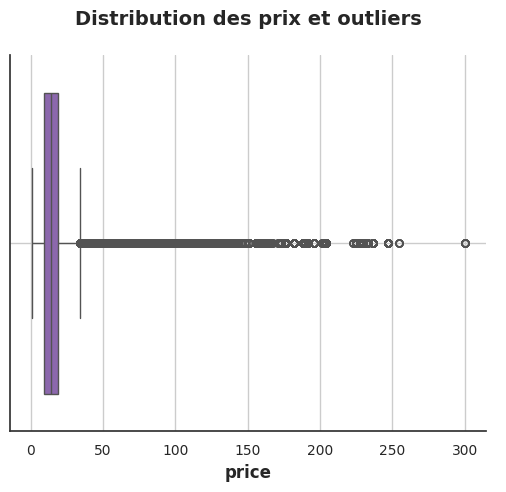

In [42]:
#Visualisation des outliers
g = sns.catplot(data = df_data, x = 'price', kind = 'box')
g.fig.suptitle('Distribution des prix et outliers', fontsize=14, fontweight= 'bold' )
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
#Création d'un dataframe sans outliers selon le critère de Tukey
Q1 = df_data['price'].quantile(0.25)
Q3 = df_data['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - IQR * 1.5
upper = Q3 + IQR * 1.5
df_data_SANS_OUTLIERS = df_data[(df_data['price'] >= lower) & (df_data['price'] <= upper)]
pourcentage = round( len(df_data_SANS_OUTLIERS)/len(df_data) *100, 2)
print("Pourcentage des données de base, après suppression des outliers :" ,pourcentage , "%")

Pourcentage des données de base, après suppression des outliers : 93.77 %


En appliquant le critère de Tukey (± 1.5 × IQR), j’obtiens un nouveau DataFrame, df_data_SANS_OUTLIERS, qui conserve environ **93,77 %** des observations initiales.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyses graphiques</h2>
</div>

### Analyses temporelles :

In [44]:
# moyenne mobile avec un .resample()
df_daily_sales =df_data.resample('D', on='date')[['price']].sum().reset_index()
df_daily_sales['mobile'] = df_daily_sales['price'].rolling(window=7).mean()
df_daily_sales.head(10)

,date,price,mobile
0,2021-03-01,16565.220703,NaN
1,2021-03-02,15486.450195,NaN
2,2021-03-03,15198.689453,NaN
3,2021-03-04,15196.070312,NaN
4,2021-03-05,17471.369141,NaN
5,2021-03-06,15785.280273,NaN
6,2021-03-07,14760.200195,15780.468610
7,2021-03-08,15679.530273,15653.941406
8,2021-03-09,15710.509766,15685.949916
9,2021-03-10,15496.870117,15728.547154


In [45]:
# Chiffre d’affaires journalier et moyenne mobile (7 jours)
df_daily_sales2 = df_data.groupby(df_data['date'].dt.date)['price'].sum().reset_index()
df_daily_sales2.rename(columns={'date': 'day', 'price': 'revenue'}, inplace=True)
df_daily_sales2 = df_daily_sales2.sort_values('day')
df_daily_sales2['revenue_rolling'] = df_daily_sales2['revenue'].rolling(window=7).mean()
df_daily_sales2.head(10)

,day,revenue,revenue_rolling
0,2021-03-01,16565.220703,NaN
1,2021-03-02,15486.450195,NaN
2,2021-03-03,15198.689453,NaN
3,2021-03-04,15196.070312,NaN
4,2021-03-05,17471.369141,NaN
5,2021-03-06,15785.280273,NaN
6,2021-03-07,14760.200195,15780.468610
7,2021-03-08,15679.530273,15653.941406
8,2021-03-09,15710.509766,15685.949916
9,2021-03-10,15496.870117,15728.547154


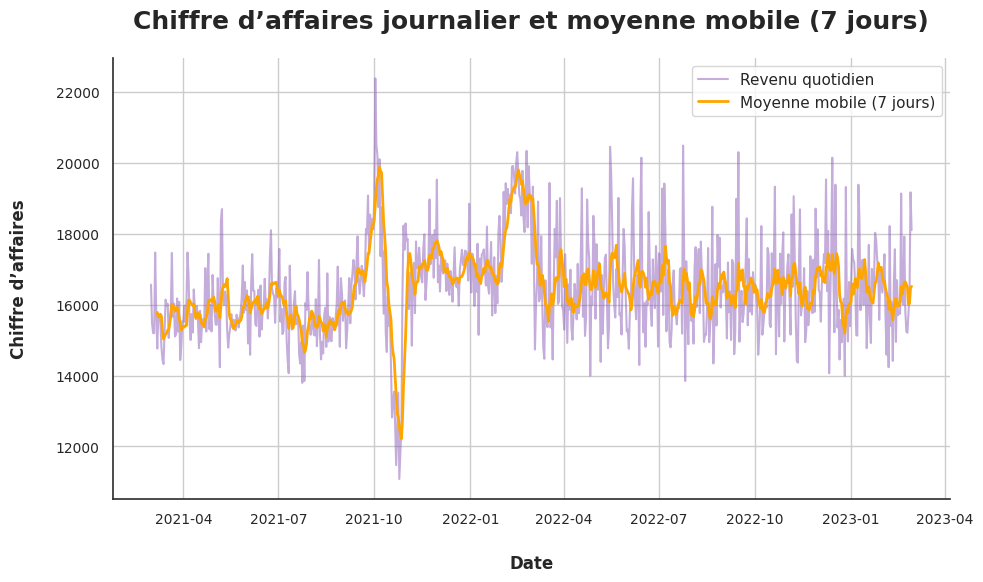

In [46]:
# Graphique du Chiffre d’affaires journalier et moyenne mobile (7 jours)
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_daily_sales2, x="day", y="revenue", label="Revenu quotidien", alpha=0.5)
sns.lineplot(data=df_daily_sales2, x="day", y="revenue_rolling", 
             label="Moyenne mobile (7 jours)", color='orange', linewidth=2)

plt.title("Chiffre d’affaires journalier et moyenne mobile (7 jours)", y =1.05, fontsize=18, fontweight='bold')
plt.xlabel("Date", labelpad=20)
plt.ylabel("Chiffre d’affaires", labelpad=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation** : La moyenne mobile marque une forte fluctuation en octobre 2021, une légère hausse vers mars 2022, mais reste sinon stable autour de **16 500 €**.

In [47]:
# Évolution des achats par catégorie dans le temps
df_grouped = df_data.groupby([df_data['date'].dt.date, 'categ']).size().reset_index(name='count')
df_grouped

,date,categ,count
0,2021-03-01,0,581
1,2021-03-01,1,335
2,2021-03-01,2,46
3,2021-03-02,0,620
4,2021-03-02,1,276
...,...,...,...
2185,2023-02-27,1,332
2186,2023-02-27,2,75
2187,2023-02-28,0,472
2188,2023-02-28,1,439


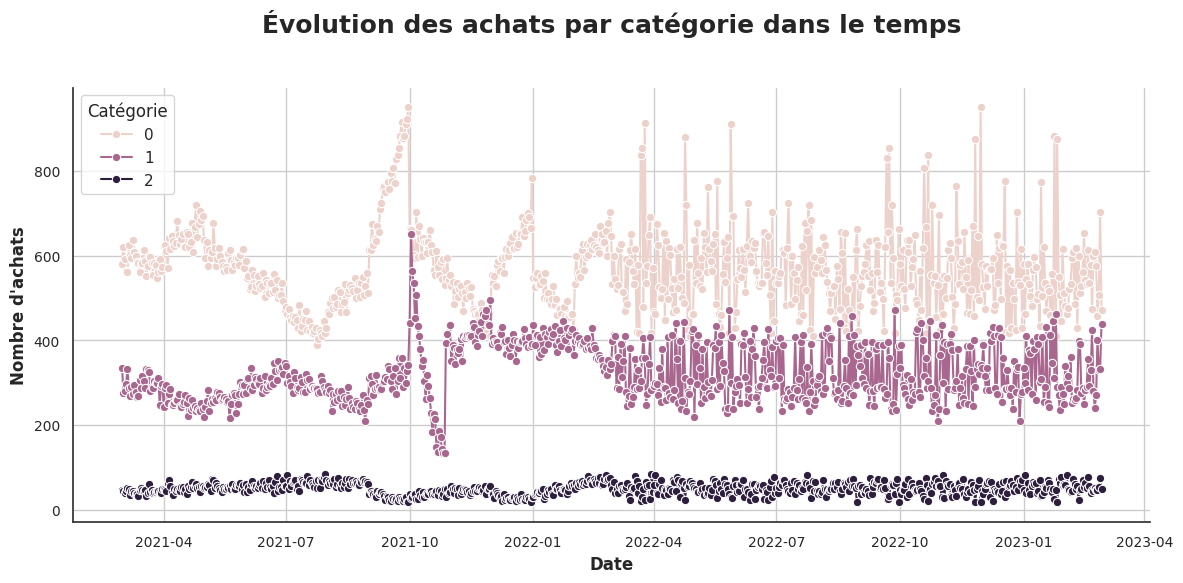

In [48]:
# Graphique de l'Évolution des achats par catégorie dans le temps
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='date', y='count', hue='categ', marker='o')

plt.title('Évolution des achats par catégorie dans le temps', pad=40, size=18, weight = "bold")
plt.xlabel('Date')
plt.ylabel('Nombre d\'achats')
plt.legend(title='Catégorie')
plt.tight_layout()

plt.show()

**Observation** : Pendant les 2 années d'observations, les catégories générant du volume d'achat restent dans une même hiérarchie => catégorie 0 > catégorie 1 > catégorie 2 .

In [49]:
#Chiffre d'affaire par catégorie
CA_categories = df_data.groupby('categ')[["price"]].sum()
CA_categories

,price
categ,
0,4419731.0
1,4827657.0
2,2780275.0


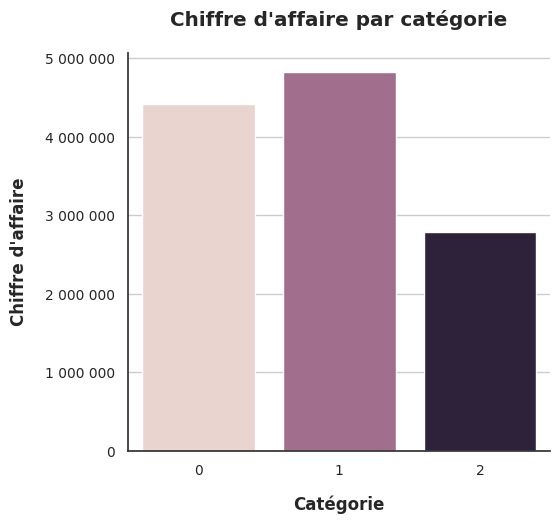

In [50]:
#Graphique du chiffre d'affaire par catégorie
g = sns.catplot(data = CA_categories, kind= 'bar', x='categ', y = 'price', hue='categ', 
                order = CA_categories.index)
g._legend.remove()
g.fig.suptitle("Chiffre d'affaire par catégorie", y = 1.02, weight = 'bold')
g.ax.set_xlabel("Catégorie", labelpad=12)
g.ax.set_ylabel("Chiffre d'affaire", labelpad=12)
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
plt.show()

**Observation** : Au total, les catégories générant du chiffre d'affaire ont cette hiérarchie => catégorie 1 > catégorie 0 > catégorie 2 .

In [51]:
df_data['mois'] = df_data['date'].dt.to_period('M').dt.to_timestamp()
df_data.head(15)

,id_prod,price,categ,date,session_id,client_id,sex,birth,mois
0,0_1421,19.99,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972,2021-03-01
1,0_1421,19.99,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967,2021-03-01
2,0_1421,19.99,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936,2021-03-01
3,0_1421,19.99,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989,2021-03-01
4,0_1421,19.99,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981,2021-03-01
5,0_1421,19.99,0,2021-03-03 11:20:13.284203,s_1163,c_1545,m,1973,2021-03-01
6,0_1421,19.99,0,2021-03-05 15:49:32.987064,s_2151,c_1437,f,2004,2021-03-01
7,0_1421,19.99,0,2021-03-05 17:10:40.265676,s_2187,c_1455,f,1932,2021-03-01
8,0_1421,19.99,0,2021-03-06 04:54:05.505267,s_2419,c_5689,m,1979,2021-03-01
9,0_1421,19.99,0,2021-03-07 14:30:19.775495,s_3063,c_8170,m,1985,2021-03-01


In [52]:
# Evolution du chiffre d'affaire par mois et par catégories
df_data['mois'] = df_data['date'].dt.to_period('M').dt.to_timestamp()
CA_par_mois_par_categories = df_data.groupby(['mois', 'categ'])['price'].sum().reset_index()
CA_par_mois_par_categories

,mois,categ,price
0,2021-03-01,0,193629.171875
1,2021-03-01,1,186974.171875
2,2021-03-01,2,101837.273438
3,2021-04-01,0,205222.453125
4,2021-04-01,1,156138.343750
...,...,...,...
67,2023-01-01,1,210104.406250
68,2023-01-01,2,126153.078125
69,2023-02-01,0,162457.000000
70,2023-02-01,1,180347.234375


In [53]:
df_data.dtypes

id_prod               object
price                float32
categ                  int32
date          datetime64[ns]
session_id          category
client_id             object
sex                 category
birth                  int32
mois          datetime64[ns]
dtype: object

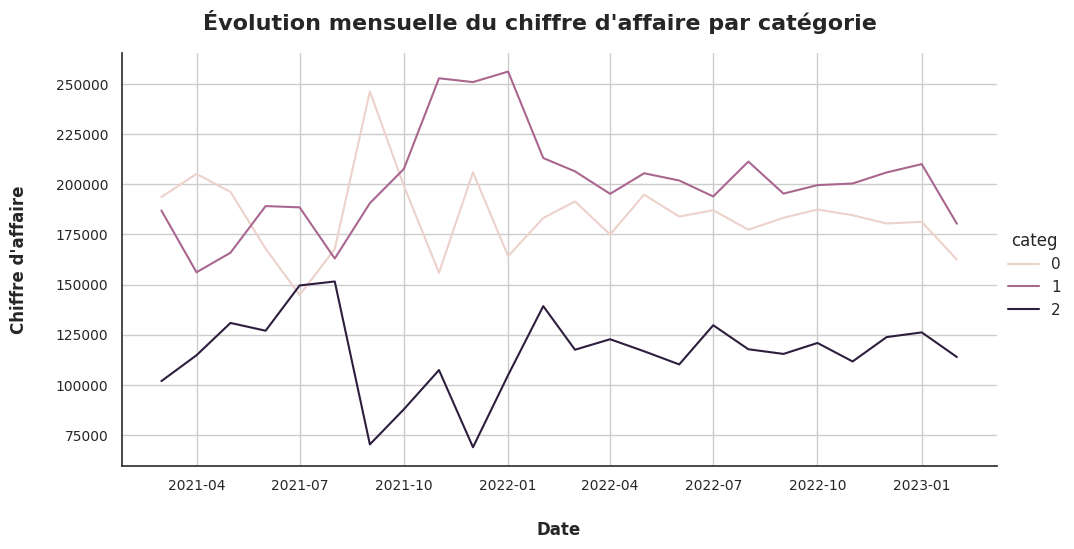

In [54]:
# Graphique de l'Evolution du chiffre d'affaire par mois
g = sns.relplot(data = CA_par_mois_par_categories,  x = 'mois', y = 'price', hue='categ', kind= 'line', aspect=2)
g.fig.suptitle("Évolution mensuelle du chiffre d'affaire par catégorie", y=1.05, fontsize= 16, fontweight = 'bold')
g.ax.set_xlabel("Date", labelpad=20)
g.ax.set_ylabel("Chiffre d'affaire", labelpad=20)
plt.show()

**Observation** : On note des fluctuations de l'évolution du chiffres d'affaire entre août 2021 et février 2022.

In [55]:
# Nombre de clients uniques par mois
clients_par_mois= df_data.resample("ME", on="date")[["client_id"]].nunique()
#clients_par_mois

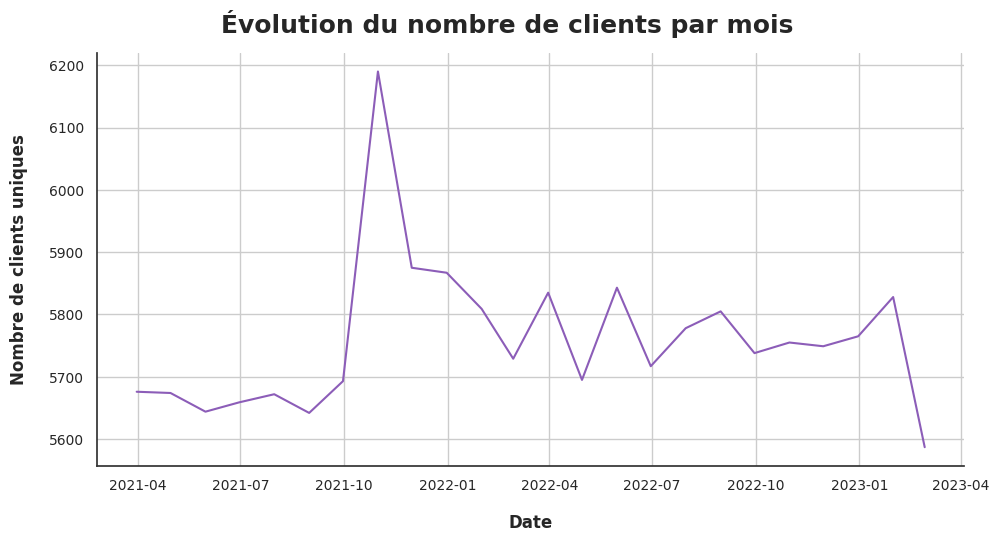

In [56]:
# Graphique du nombre de clients uniques par mois
g = sns.relplot(data = clients_par_mois, x='date', y = "client_id", kind ='line', aspect=2)
g.fig.suptitle("Évolution du nombre de clients par mois", y = 1.05, fontsize = 18, fontweight = 'bold')
g.ax.set_xlabel("Date", labelpad=15)  
g.ax.set_ylabel("Nombre de clients uniques", labelpad=15)  
plt.show()

**Observation** : On note un pic de l'évolution du nombre de clients uniques vers novembre 2021, mais une chute à surveiller vers mars 2023. 

In [57]:
# Nombre de transactions par mois
df_data_2 = df_data.set_index('date')
transactions_par_mois = df_data_2.resample('ME').size().reset_index(name='nb_transactions')

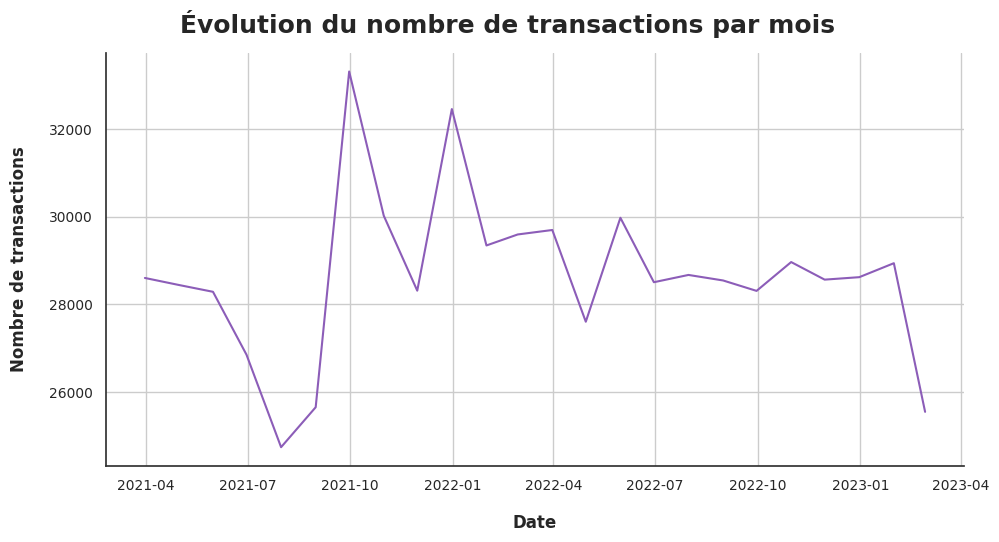

In [58]:
# Graphique du Nombre de transactions par mois
g = sns.relplot(data= transactions_par_mois, x ='date', y = 'nb_transactions', kind = 'line', aspect=2)
g.fig.suptitle("Évolution du nombre de transactions par mois", y =1.05, fontsize = 18, fontweight = 'bold')
g.ax.set_xlabel("Date", labelpad=15)  
g.ax.set_ylabel('Nombre de transactions', labelpad=15) 
plt.show()

**Observation** : On note une chute du nombre de transactions vers août 2021, mais une chute à surveiller vers mars 2023. 

In [59]:
# Calcul du chiffre d'affaire moyen à la journée
CA_day= df_data.resample('D', on ='date')[['price']].sum()
Ca_par_jour = round(CA_day['price'].mean(), 2)
print("Chiffre d'affaires journalier moyen :", Ca_par_jour, "€")

Chiffre d'affaires journalier moyen : 16476.25 €


In [60]:
# Calcul du chiffre d'affaire moyen à la semaine avec .resample()
CA_par_semaine = df_data.resample('W-MON', on ='date')[['price']].sum()
print("Chiffre d'affaires hebdomadaire moyen :", round(CA_par_semaine['price'].mean(), 2), "€")

Chiffre d'affaires hebdomadaire moyen : 113468.52 €


In [61]:
# Calcul du chiffre d'affaire moyen à la semaine
df_data['semaine'] = df_data['date'].dt.to_period('W-MON').dt.to_timestamp()
CA_par_semaine2 = df_data.groupby('semaine')['price'].sum().reset_index()
CA_semaine_moyen2 = round( CA_par_semaine['price'].mean(), 2)
print("Chiffre d'affaires hebdomadaire moyen :", CA_semaine_moyen2 , "€")

Chiffre d'affaires hebdomadaire moyen : 113468.52 €


**LES TOP 20**

In [62]:
# Top 20 des clients qui ont le plus achetés
top_clients_count = df_data['client_id'].value_counts().head(20).reset_index()
top_clients_count.columns = ['client_id', 'nb_achats']

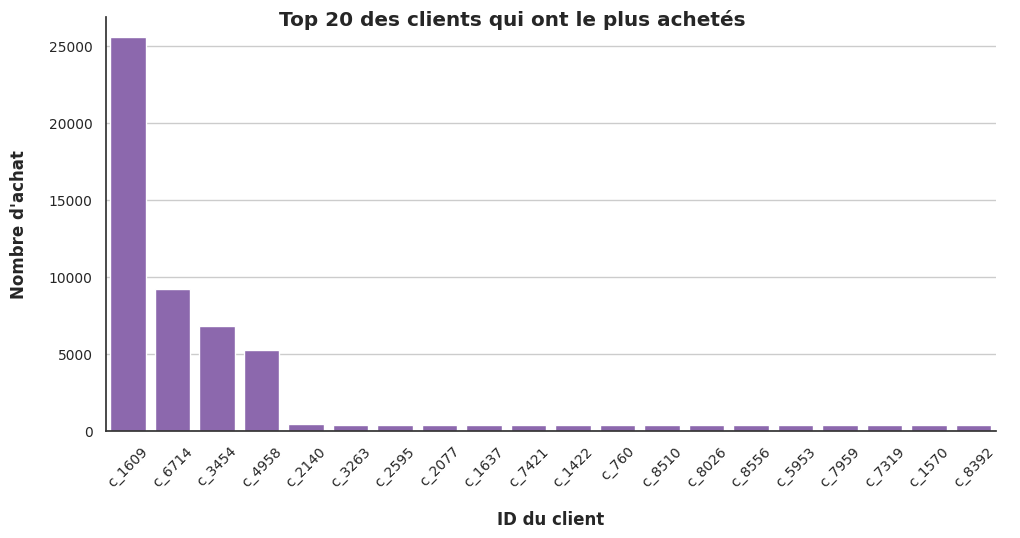

In [63]:
#Graphique Top 20 des clients qui ont le plus achetés
g = sns.catplot(data = top_clients_count, x ='client_id', y = "nb_achats", kind= 'bar', aspect = 2)
g.fig.suptitle("Top 20 des clients qui ont le plus achetés", fontweight = 'bold')
g.ax.set_xlabel("ID du client", labelpad=15)  
g.ax.set_ylabel("Nombre d'achat", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

**Observation** : On remarque 4 clients uniques qui se démarquent des autres pour leur nombre d'achat.

In [64]:
# Top 20 des clients qui ont le plus générés de chiffres d'affaires
top_clients_CA = df_data.groupby('client_id')['price'].sum().sort_values(ascending=False).head(20).reset_index()
top_clients_CA = top_clients_CA.rename(columns={"client_id" : "client_id","price": "total_revenue"})

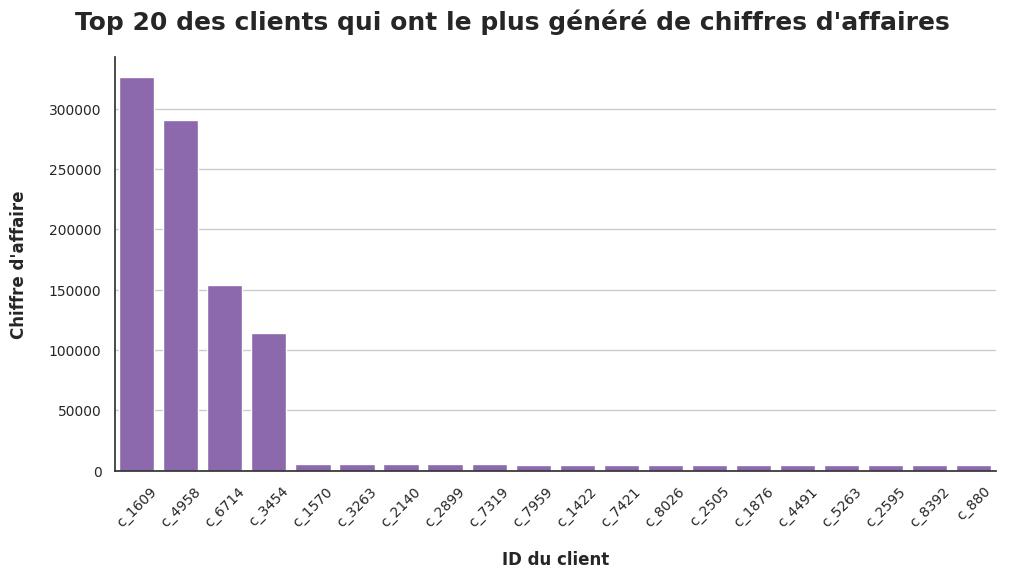

In [65]:
#Graphique Top 20 des clients qui ont le plus généré de chiffres d'affaires
g = sns.catplot(data = top_clients_CA, x = "client_id", y = "total_revenue", kind = "bar", aspect= 2)
g.fig.suptitle("Top 20 des clients qui ont le plus généré de chiffres d'affaires",
               y=1.06, fontsize = 18, fontweight = 'bold')
g.ax.set_xlabel("ID du client", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

**Observation** : On remarque 4 clients uniques qui se démarquent pour la génération de chiffre d'affaire. Ce sont les 4 mêmes qui génèrent le plus d'achat.

**Analyse sur les produits :**

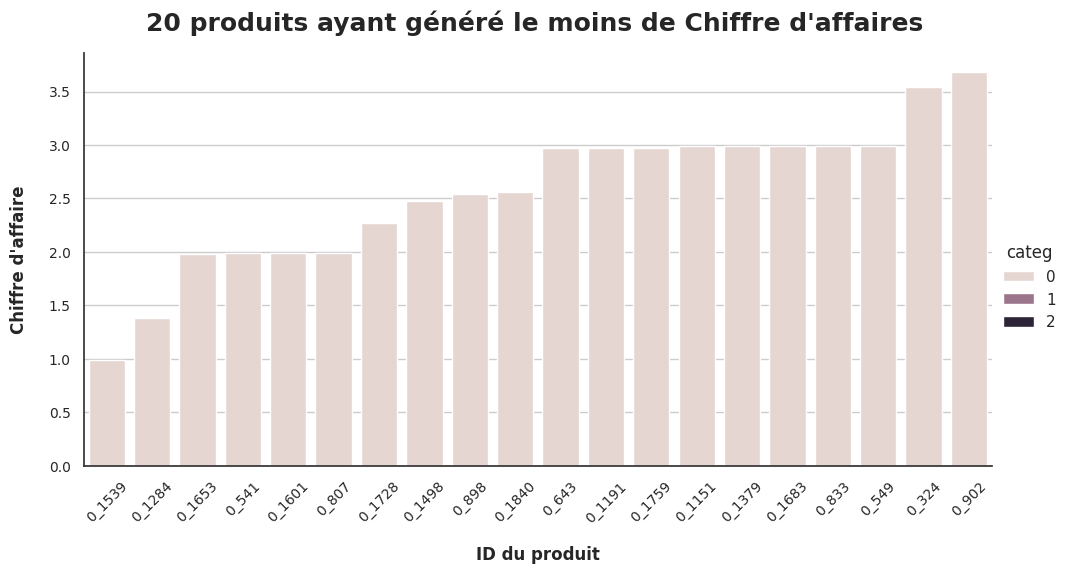

In [66]:
# FLOP 20 Produits qui ont le moins générés de Chiffre d'affaires

flop_20 = df_data.groupby(['id_prod', 'categ'])[['price']].sum()
flop_20 = flop_20.sort_values('price').head(20).reset_index()

#Visualisasion
categs = sorted(df_data['categ'].unique()) 
palette = {0: '#e9d4cf', 1: '#a06f8d', 2: '#2d223a'}
flop_20 ['categ'] = pd.Categorical(flop_20 ['categ'], categories=categs)

g = sns.catplot(data = flop_20, x= 'id_prod', y = 'price', hue='categ', kind = 'bar', aspect= 2, palette = palette)
g.fig.suptitle("20 produits ayant généré le moins de Chiffre d'affaires", y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("ID du produit", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

**Observation** : Seuls les livres de la catégorie 0 sont présents dans le FLOP 20 dans articles ayant le moins générés de chiffre d'affaires.

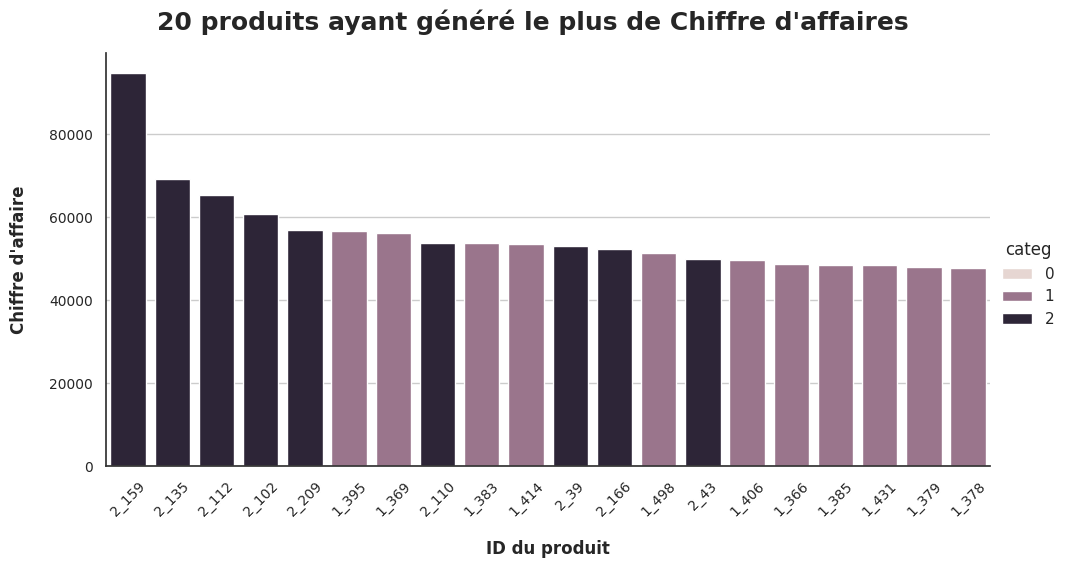

In [67]:
# TOP 20
top_20 = df_data.groupby(['id_prod', 'categ'])[['price']].sum()
top_20 = top_20.sort_values('price', ascending = False).head(20).reset_index()

#Visualisasion
categs = sorted(df_data['categ'].unique()) 
palette = {0: '#e9d4cf', 1: '#a06f8d', 2: '#2d223a'}
top_20 ['categ'] = pd.Categorical(top_20 ['categ'], categories=categs)

g = sns.catplot(data = top_20, x= 'id_prod', y = 'price', hue='categ', kind = 'bar', aspect= 2, palette = palette)
g.fig.suptitle("20 produits ayant généré le plus de Chiffre d'affaires", y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("ID du produit", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

**Observation** : Les livres de catégorie 1 et 2 sont présents dans le TOP 20, mais aucun de la catégorie 0 

### Courbe de Lorenz :

In [68]:
# Préparation à la Courbe de Lorenz
Ca_par_client = df_data.groupby('client_id')[['price']].sum()
sorted_values = np.sort(Ca_par_client['price'].values)

# Cumul des valeurs
cumulative = np.cumsum(sorted_values)

# Normalisation
cumulative_percent = cumulative / cumulative[-1]  # cumulé / total
x = np.linspace(0.0, 1.0, len(cumulative_percent))

# Ajout de 0 au début pour la courbe
x = np.insert(x, 0, 0)
cumulative_percent = np.insert(cumulative_percent, 0, 0)

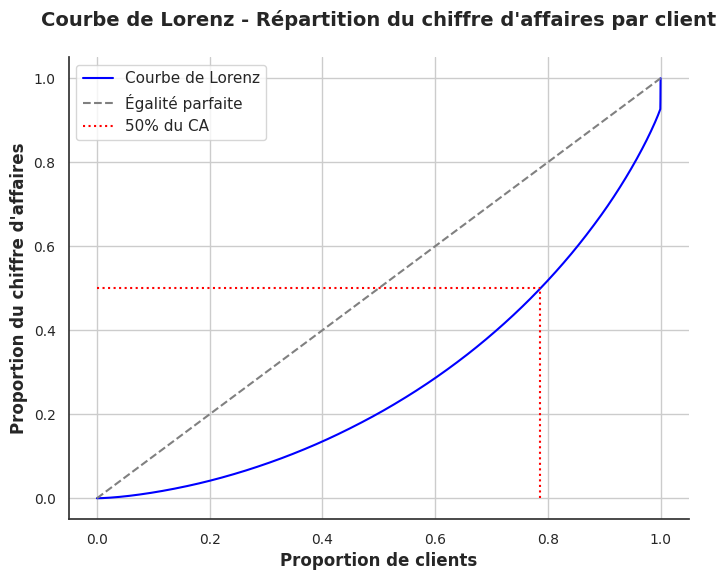

In [69]:
#Courbe de Lorenz
plt.figure(figsize=(8, 6))
plt.plot(x, cumulative_percent, label='Courbe de Lorenz', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Égalité parfaite')

x_median = np.interp(0.5, cumulative_percent, x) 
plt.plot([0, x_median], [0.5, 0.5], color='red', linestyle=':', label='50% du CA')
plt.plot([x_median, x_median], [0, 0.5], color='red', linestyle=':')

plt.title("Courbe de Lorenz - Répartition du chiffre d'affaires par client", y=1.05, fontweight = 'bold')
plt.xlabel("Proportion de clients")
plt.ylabel("Proportion du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Indice de GINI
gini = 1 - 2 * np.trapezoid(cumulative_percent, x)
print(f"Indice de Gini : {gini:.4f}")

Indice de Gini : 0.4418


On note des inégalités **modérées à fortes**, une minorité de clients, environ **22 %**,  génèrent **50 %** du chiffre d'affaires.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Tests d'Hypothèses</h2>
</div>

**TEST 1 : lien entre le genre d’un client et les catégories des livres achetés.**

In [71]:
grouped = df_data.groupby(['categ', 'sex'], observed = True).size().reset_index(name='compte')
grouped2 = df_data.groupby('categ').size().reset_index(name='total')
grouped2

,categ,total
0,0,415459
1,1,235592
2,2,36483


In [72]:
grouped 

,categ,sex,compte
0,0,f,206103
1,0,m,209356
2,1,f,119307
3,1,m,116285
4,2,f,17283
5,2,m,19200


In [73]:
df_test_1 = grouped2.merge(grouped, on ='categ')
df_test_1['pourcent'] = df_test_1['compte'] / df_test_1['total'] * 100
df_test_1

,categ,total,sex,compte,pourcent
0,0,415459,f,206103,49.608505
1,0,415459,m,209356,50.391495
2,1,235592,f,119307,50.641363
3,1,235592,m,116285,49.358637
4,2,36483,f,17283,47.372749
5,2,36483,m,19200,52.627251


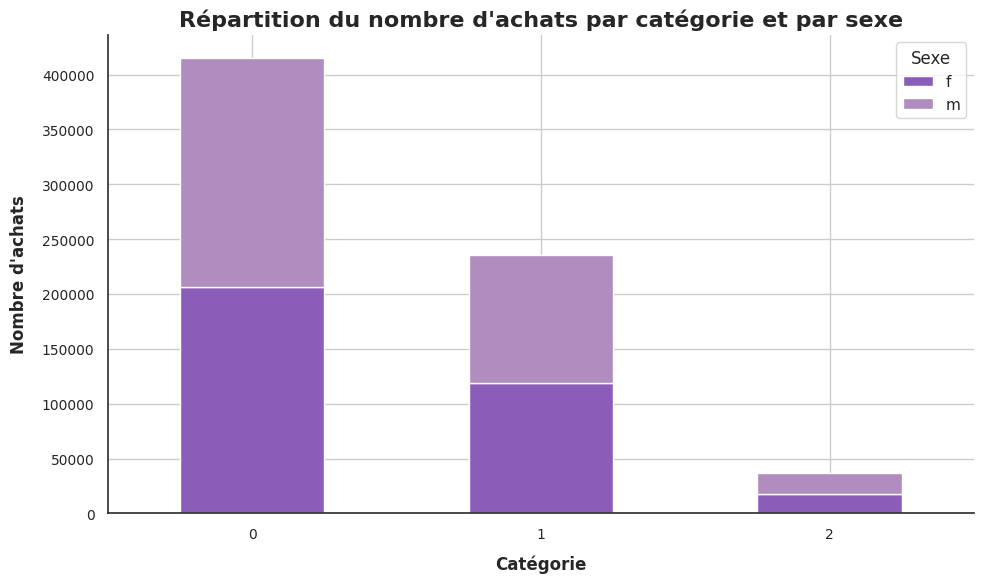

In [74]:
# Visualisation
df_pivot = df_test_1.pivot_table(
    index='categ',
    columns='sex',
    values='compte',
    aggfunc='sum',
    fill_value=0,
    observed=False
)
ax = df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
)
plt.title("Répartition du nombre d'achats par catégorie et par sexe", fontsize=16, fontweight='bold')
plt.xlabel("Catégorie", labelpad=10)
plt.ylabel("Nombre d'achats", labelpad=10)
plt.xticks(rotation=0)
plt.legend(title='Sexe')
plt.tight_layout()
plt.show()

In [75]:
# Test
contingency_table = pd.crosstab(df_data['categ'], df_data['sex'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi² = {chi2}")
print(f"p-value = {p_value}")

Chi² = 158.25417617304882
p-value = 4.3205822283997063e-35


In [76]:
contingency_table

sex,f,m
categ,,
0,206103,209356
1,119307,116285
2,17283,19200


In [77]:
# TEST de proportion à deux échantillons
categories = df_test_1['categ'].unique()

for cat in sorted(categories):
    subset = df_test_1[df_test_1['categ'] == cat]
    
    # Extraire les succès et les nobs pour f et m
    successes = subset['compte'].tolist()
    nobs = subset['total'].tolist()
    
    z_score, pval = proportions_ztest(successes, nobs)
    
    print(f"\nCatégorie {cat}:")
    print(f"  - Proportion femmes : {successes[0] / nobs[0]:.2%}")
    print(f"  - Proportion hommes : {successes[1] / nobs[1]:.2%}")
    print(f"  - Z = {z_score:.4f}, p-value = {pval:.4f}")
    
    # Interprétation
    alpha = 0.05
    if pval < alpha:
        print(f"  →  Différence significative entre hommes et femmes (p < {alpha})")
    else:
        print(f"  →  Aucune différence significative (p ≥ {alpha})")


Catégorie 0:
  - Proportion femmes : 49.61%
  - Proportion hommes : 50.39%
  - Z = -7.1373, p-value = 0.0000
  →  Différence significative entre hommes et femmes (p < 0.05)

Catégorie 1:
  - Proportion femmes : 50.64%
  - Proportion hommes : 49.36%
  - Z = 8.8050, p-value = 0.0000
  →  Différence significative entre hommes et femmes (p < 0.05)

Catégorie 2:
  - Proportion femmes : 47.37%
  - Proportion hommes : 52.63%
  - Z = -14.1936, p-value = 0.0000
  →  Différence significative entre hommes et femmes (p < 0.05)


**Une différence statistiquement significative entre hommes et femmes est observée dans chacune des trois catégories.**

**TEST 2 : le lien entre l'âge des clients et le montant total des achats.**

In [78]:
# Création de la colonne 'âge'
df_data['birth'] = pd.to_datetime(df_data['birth'], format='%Y')
df_data['âge'] = df_data['date'].dt.year - df_data['birth'].dt.year

In [79]:
test2a = df_data.groupby('client_id', observed= True).agg({'âge': 'first', 'price': 'sum'}).reset_index()
test2a

,client_id,âge,price
0,c_1,66,629.020020
1,c_10,65,1353.599976
2,c_100,29,254.850006
3,c_1000,55,2291.879883
4,c_1001,39,1823.849976
...,...,...,...
8595,c_995,66,189.410004
8596,c_996,51,1637.339966
8597,c_997,27,1490.010010
8598,c_998,20,2822.219971


In [80]:
#test2 = df_data.groupby('âge')[['price']].sum()

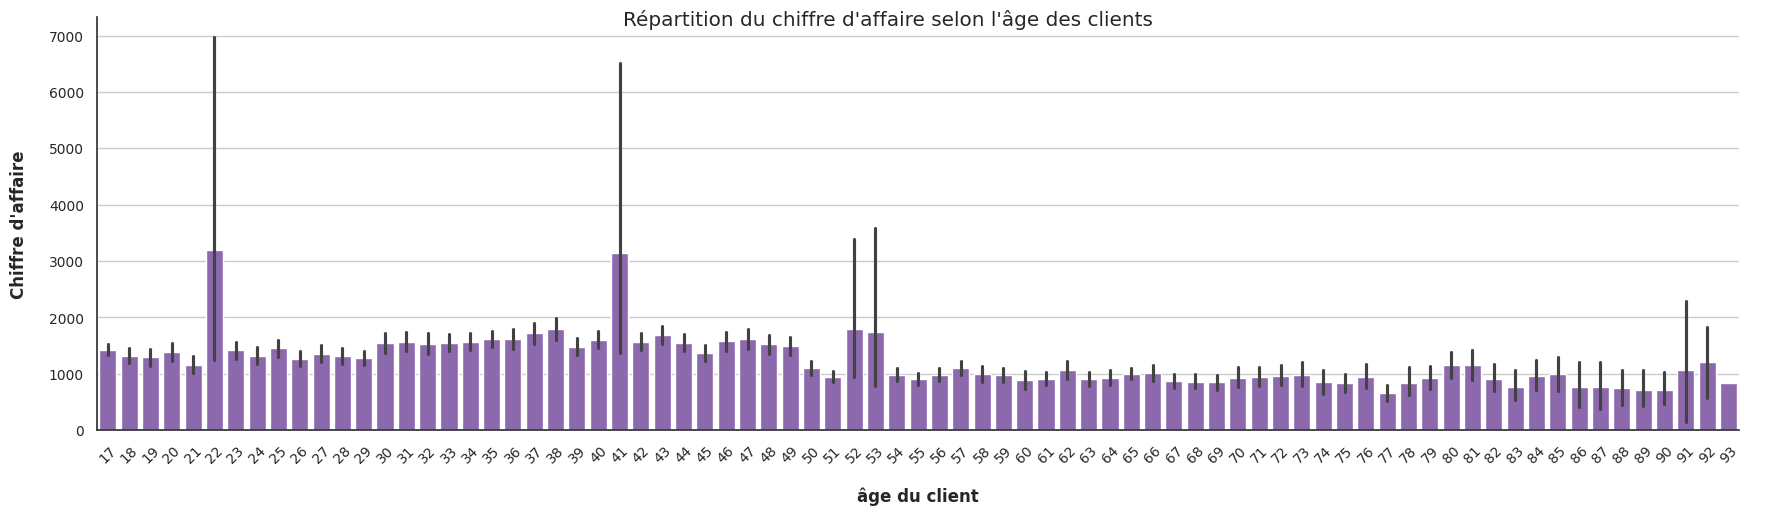

In [81]:
# Visualisation du test 2 
g = sns.catplot(data= test2a, x = "âge", y='price', kind='bar', aspect =3.5)
g.fig.suptitle("Répartition du chiffre d'affaire selon l'âge des clients")
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Chiffre d'affaire", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

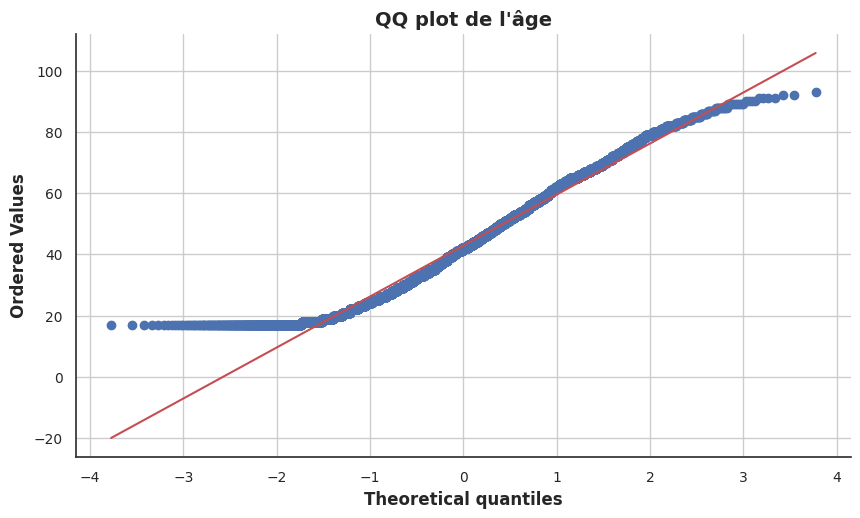

In [82]:
# QQPLOT pour choisir le type de test
stats.probplot(test2a['âge'], dist="norm", plot=plt)
plt.title("QQ plot de l'âge")
plt.show()

**Je remarque une distribution non normale de la variable 'âge', je décide d'utiliser un test non paramétrique.**

In [83]:
# Corrélation de Spearman (car données non normales)
rho, p_spearman = spearmanr(test2a['âge'], test2a['price'])
print(f"Corrélation de Spearman : rho = {rho:.3f}, p-value = {p_spearman:.3e}")

Corrélation de Spearman : rho = -0.184, p-value = 2.741e-66


**Hypothèse nulle rejetée** → il y a bien une corrélation entre **l'âge** et le **montant total des achats**.    
Relation **négative modeste** : les clients plus âgés ont tendance à dépenser légèrement moins.
Effet faible : ni ici ni dans un contexte métier, ce lien n’est très fort ou déterminant.

**TEST 3 : le lien entre l'âge des clients et la fréquence d’achat.**

In [84]:
# Nombre total d’achats effectués par des clients d’un certain âge
test3 = df_data.groupby('âge').size().reset_index()
test3 = test3.rename(columns={0 : "compte"})
test3

,âge,compte
0,17,6283
1,18,9756
2,19,5535
3,20,4556
4,21,4421
...,...,...
73,90,243
74,91,222
75,92,197
76,93,129


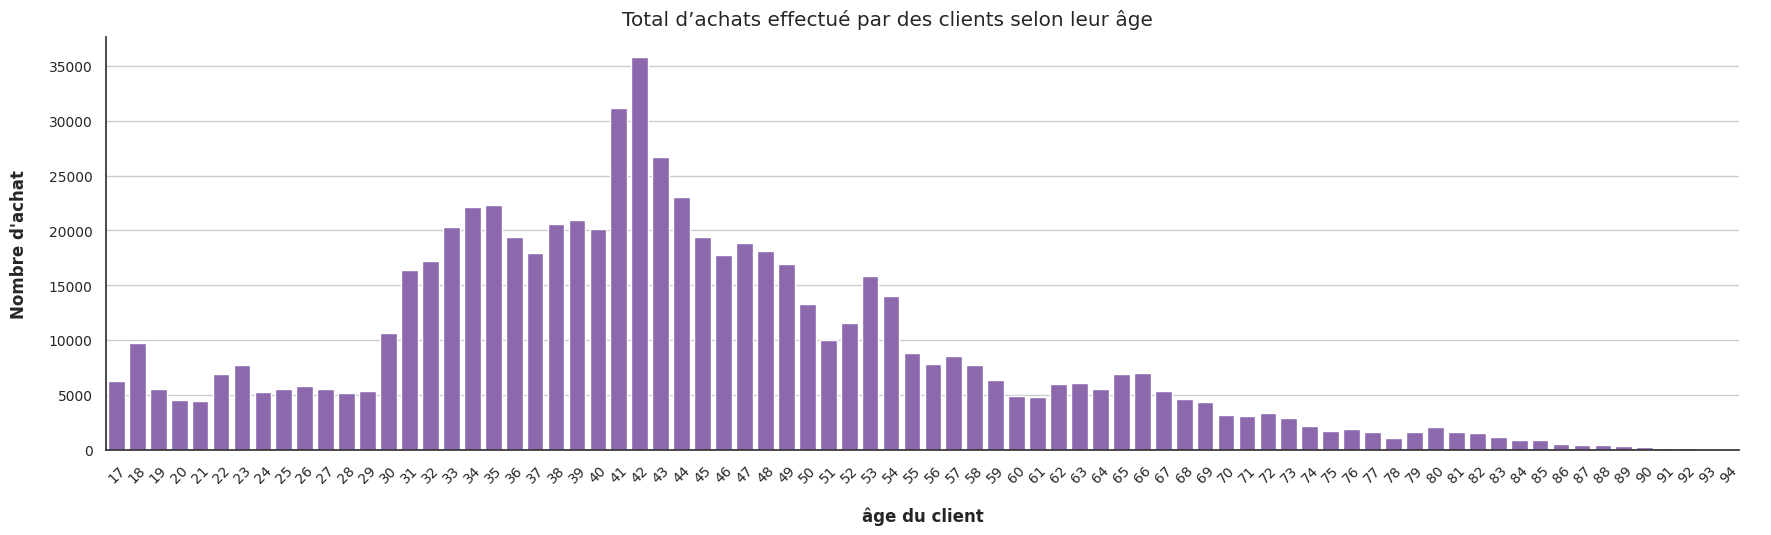

In [85]:
# Visualisation total d’achats effectués par des clients d’un certain âge
g = sns.catplot(data= test3, x = "âge", y='compte', kind='bar', aspect =3.5)
g.fig.suptitle("Total d’achats effectué par des clients selon leur âge", 
               y= 1.02)
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Nombre d'achat", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

In [86]:
df_data

,id_prod,price,categ,date,session_id,client_id,sex,birth,mois,semaine,âge
0,0_1421,19.990000,0,2021-03-01 04:13:00.107748,s_101,c_8533,m,1972-01-01,2021-03-01,2021-02-23,49
1,0_1421,19.990000,0,2021-03-01 13:48:20.214075,s_285,c_5299,f,1967-01-01,2021-03-01,2021-02-23,54
2,0_1421,19.990000,0,2021-03-01 15:07:42.730079,s_317,c_8024,f,1936-01-01,2021-03-01,2021-02-23,85
3,0_1421,19.990000,0,2021-03-02 03:39:21.811833,s_563,c_7702,f,1989-01-01,2021-03-01,2021-03-02,32
4,0_1421,19.990000,0,2021-03-02 19:09:41.789425,s_850,c_4057,m,1981-01-01,2021-03-01,2021-03-02,40
...,...,...,...,...,...,...,...,...,...,...,...
687529,1_140,38.560001,1,2022-12-09 14:20:34.169187,s_309513,c_7406,m,1988-01-01,2022-12-01,2022-12-06,34
687530,0_1920,25.160000,0,2021-04-13 18:36:10.252971,s_20115,c_7088,m,1987-01-01,2021-04-01,2021-04-13,34
687531,0_1920,25.160000,0,2021-05-30 02:37:22.371278,s_41465,c_7748,f,1989-01-01,2021-05-01,2021-05-25,32
687532,0_1920,25.160000,0,2022-12-30 02:37:22.371278,s_319303,c_7748,f,1989-01-01,2022-12-01,2022-12-27,33


In [87]:
# TEST3
freq_par_client = df_data.groupby('client_id').size().reset_index(name='nb_achats')

age_par_client = df_data.groupby('client_id')['âge'].first().reset_index()

df_test3 = freq_par_client.merge(age_par_client, on='client_id')


rho, p = spearmanr(df_test3['âge'], df_test3['nb_achats'])
print("Coefficient de corrélation de Spearman :", rho)
print("p-value :", p)

Coefficient de corrélation de Spearman : 0.12788766962919493
p-value : 1.0880812633211114e-32


Le test de corrélation de Spearman met en évidence une corrélation positive mais faible entre l’âge des clients et leur nombre d’achats (ρ = 0.128).
Cette relation est statistiquement significative (p-value < 0.001), probablement en raison de la grande taille de l’échantillon.
Toutefois, l’intensité de la relation reste faible, ce qui suggère que l’âge explique peu la variabilité du nombre d’achats.

**TEST 4 : le lien entre l'âge des clients et la taille du panier moyen.**

In [88]:
# Regroupement par session : une ligne = une session
test4 = df_data.groupby('session_id', observed = True).agg({'price': 'sum', 'âge': 'first'}).reset_index()
test4.rename(columns={'price': 'taille_panier'}, inplace=True)
test4

,session_id,taille_panier,âge
0,s_1,11.990000,54
1,s_10,26.990000,51
2,s_100,33.720001,43
3,s_1000,39.220001,32
4,s_10000,41.489998,32
...,...,...,...
345500,s_99995,19.840000,61
345501,s_99996,56.270000,47
345502,s_99997,6.990000,42
345503,s_99998,35.110001,43


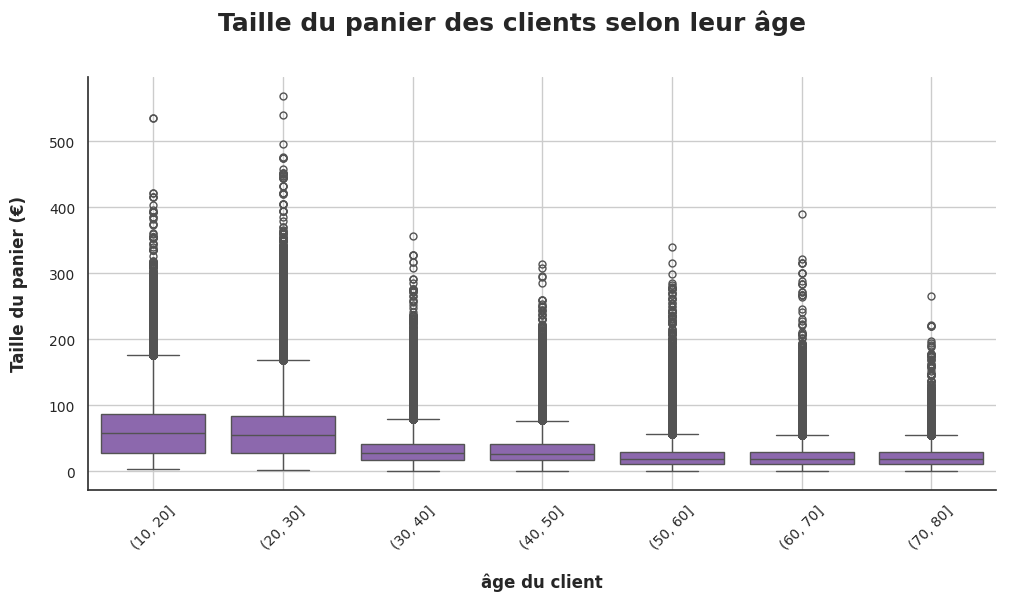

In [89]:
#Visualisation de la Taille du panier des clients selon leur âge
test4['tranche_âge'] = pd.cut(test4['âge'], bins=[10, 20, 30, 40, 50, 60, 70, 80])
g =sns.catplot(data = test4, x = 'tranche_âge', y='taille_panier', kind = 'box', aspect = 2)
g.fig.suptitle("Taille du panier des clients selon leur âge", 
               y= 1.1, fontsize=18, fontweight='bold')
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Taille du panier (€)", labelpad=15) 
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [90]:
# Test par une Régression linéaire
new = ols("taille_panier~âge", data= test4).fit()
p_value = new.pvalues['âge']
coef_age = new.params['âge']
print(f"La p-value pour l'âge est : {p_value}")
print(f"Le coefficient pour l'âge est : {coef_age:.3f}")

La p-value pour l'âge est : 0.0
Le coefficient pour l'âge est : -0.714


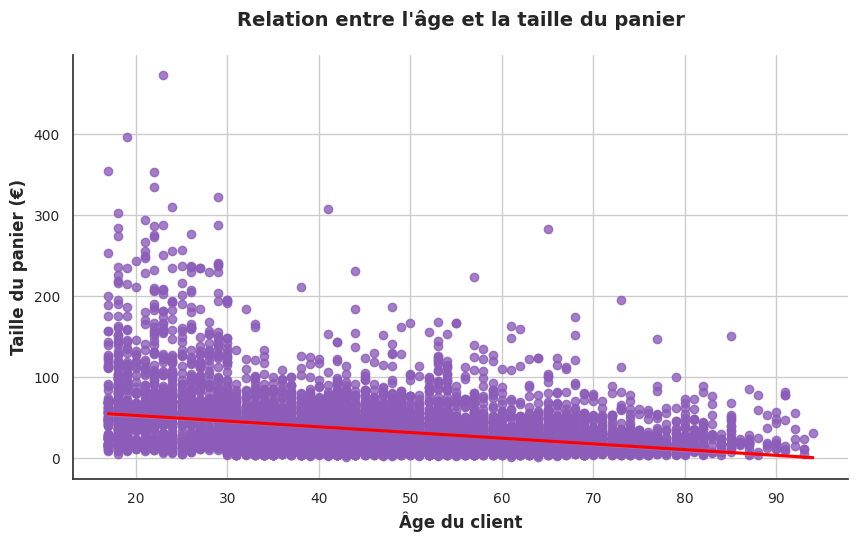

In [91]:
# Visualisation de la Régression linéaire
df_sample = test4.sample(n=10000, random_state=42)
sns.regplot(data=df_sample, x="âge", y="taille_panier", line_kws={"color": "red"})
plt.title("Relation entre l'âge et la taille du panier", y=1.05,  fontweight = 'bold')
plt.xlabel("Âge du client")
plt.ylabel("Taille du panier (€)")
plt.show()

**L'effet de l'âge est statistiquement significatif (p-value ≈ 0). Chaque année d'âge en plus est associée à une diminution moyenne de 0.714 € de la taille du panier.**

**TEST 5 : le lien entre l'âge des clients et la catégorie des
livres achetés.**

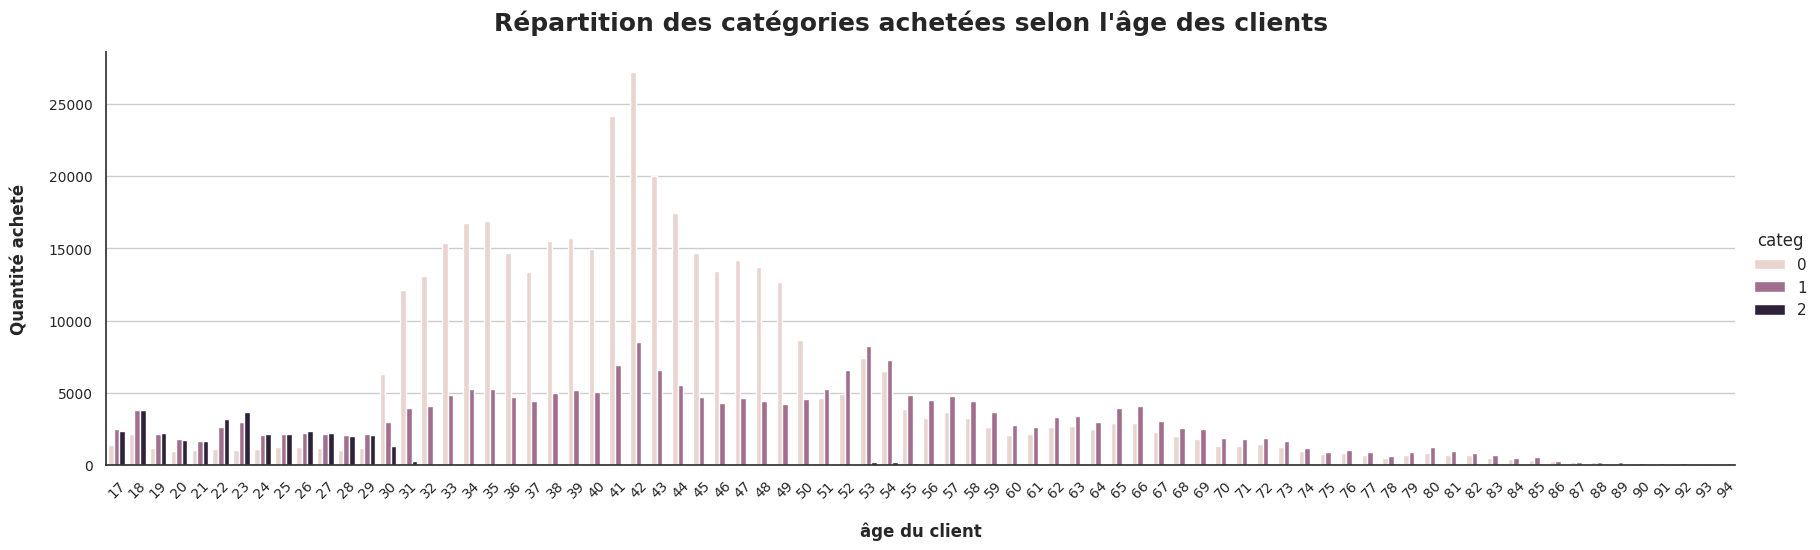

In [92]:
test5 = df_data.groupby(['âge', 'categ']).size().reset_index(name='compte')
g = sns.catplot(data= test5, x = "âge", y='compte', kind='bar', hue='categ', aspect =3.5)
g.fig.suptitle("Répartition des catégories achetées selon l'âge des clients", 
               y= 1.05, fontsize=18, fontweight='bold')
g.ax.set_xlabel("âge du client", labelpad=15)  
g.ax.set_ylabel("Quantité acheté", labelpad=15) 
plt.xticks(rotation=45)
plt.show()

In [93]:
# Méthode avec pingouin
df_data['classe_âge'] = pd.cut(df_data['âge'], bins=range(0, 110, 10), right=False)
expected, observed, stats = pingouin.chi2_independence(data=df_data, x='classe_âge', y='categ')
print(stats)

                 test    lambda           chi2   dof  pval    cramer  power
0             pearson  1.000000  284989.315768  16.0   0.0  0.455252    1.0
1        cressie-read  0.666667  237788.341791  16.0   0.0  0.415847    1.0
2      log-likelihood  0.000000  194844.618855  16.0   0.0  0.376428    1.0
3       freeman-tukey -0.500000  191318.100609  16.0   0.0  0.373006    1.0
4  mod-log-likelihood -1.000000  209542.855474  16.0   0.0  0.390368    1.0
5              neyman -2.000000  373697.534698  16.0   0.0  0.521312    1.0


In [94]:
# Méthode avec chi2_contingency
test5.columns = ['âge', 'categ', 'count']  

# Création de la table de contingence
contingency_table = test5.pivot(index='âge', columns='categ', values='count').fillna(0)

# Application du test du khi²
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi² = {chi2:.2f}")
print(f"p-value = {p:.4f}")

Chi² = 292337.74
p-value = 0.0000


**Avec une p_value = 0, On obtient cette conclusion statistique : Il existe une association statistiquement significative entre l’âge et la catégorie de produit achetée.**

**CONCLUSION FINALE** : Environ **22 %** des clients génèrent **50 %** du chiffre d'affaire de la librairie.
Les livres de catégorie 2, générant un chiffre d'affaire nettement moindre que les deux autres, sont principalement achetés par une **clientèle jeune** (18 à 30 ans). Le **chiffre d'affaire journalier moyen** est d'environ **16 500 €** sur la période étudiée.

In [95]:
from datetime import timedelta

ref_date = df_data['date'].max()

rfm = df_data.groupby('client_id').agg({
    'date': lambda x: (ref_date - x.max()).days,  # R
    'session_id': 'nunique',                      # F
    'price': 'sum'                                # M
}).rename(columns={'date': 'Recency', 'session_id': 'Frequency', 'price': 'Monetary'})


In [96]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'], 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [97]:
rfm['RFM_score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)
